In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import SimpleITK as sitk
import tensorflow as tf
from tensorflow import keras
from keras.layers import AveragePooling3D

import time
import copy
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import os
import imageio
import pydicom as dicom  # pip install pydicom
import pandas as pd
import sys

import SimpleITK
from scipy import ndimage as ndi
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import disk, dilation, binary_erosion, binary_closing
from skimage.filters import roberts, sobel
import cv2
from KEM_EXPE import *
from experiment_auxiliary import *
import re

sys.path.append('../')
sys.path.append('../Models/')

from utils import *
from GMM import *
from Kmeans import *
%matplotlib inline

In [3]:
depth = 99                # the depth th slice will be shown
index_list = [2, 19, 47]  # randomly selected patient index

path = '/database/datasets/Classics/LIDCdata/'  # LIDC dataset (a subset)
patient_folders = os.listdir(path)
print(len(patient_folders))

158


- manually set the following index {0, 1, 2} then run the following codes

In [4]:
index = index_list[0]  # {0, 1, 2}

In [5]:
original_folder = get_patient_folder(path, index)  # raw CT data folder
name = copy.copy(original_folder)
name = re.findall('LIDC-IDRI-[0-9]*', name)[0]     # CT data name, e.g., 'LIDC-IDRI-0405'
patient_folder = get_patient_folder(path, index)   # the patient's folder

# read in experiment data
experiment_data, slope, intercept = load_experiment_data_lidc(patient_folder)
print(experiment_data.shape)

(260, 512, 512)


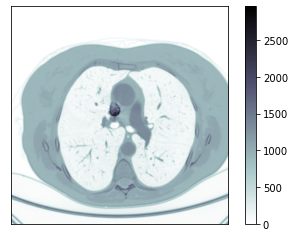

In [6]:
# show example slice
show_slice(experiment_data[depth], None, True)

# Lung Concentration

In [7]:
lung_threshold = -200

t1 = time.time()
concentrated_data = lung_concentration(experiment_data, lung_threshold, slope, intercept)
t2 = time.time()
print(f"lung concentration: {t2 - t1:.6f}")

lung concentration: 23.141058


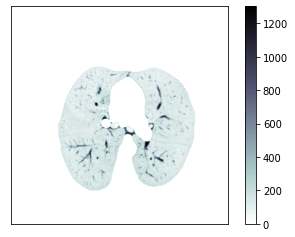

In [9]:
show_slice(concentrated_data[depth], None, True)

In [10]:
# save the concentrated lung
# output_folder = f"./[ConcetratedLung]-{name}/" 
# tmp = transfer_pi_to_dicom_raw(concentrated_data, original_folder, output_folder, truncate_threshold=None)

In [11]:
# plt.imshow(tmp[depth])

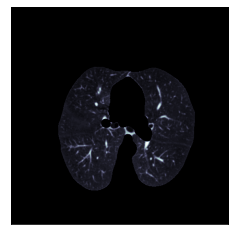

In [23]:
# rescale the data
CT_min = concentrated_data.min()
CT_max = concentrated_data.max()
concentrated_data = (concentrated_data - CT_min) / (CT_max - CT_min)

# Here, I changed the colormap from plt.cm.bone_r to plt.cm.bone
show_slice(concentrated_data[depth], title=None, Bar=False, OutLines=True, Bar_range=None, cmap=plt.cm.bone)

In [24]:
shape = concentrated_data.shape
experiment_data = tf.cast(tf.convert_to_tensor(concentrated_data), tf.float32)
experiment_data = tf.reshape(experiment_data, (1,) + experiment_data.shape + (1,))

2024-03-28 13:04:16.806375: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 13:04:17.358375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:34:00.0, compute capability: 8.0


# KEM Algorithm

In [25]:
np.random.seed(0)
tf.random.set_seed(0)

In [26]:
Ch = 0.2217
sample_size = shape[0] * shape[1] * shape[2]
bandwidth_base = sample_size**(-1/7)
optimal_bandwidth = Ch * bandwidth_base
kernel_shape = (3, 3, 3)
# optimal_bandwidth = 10 / 512

In [27]:
# use all the data
training_ratio = 1
position_mask = np.random.binomial(n=1, p=training_ratio, size=experiment_data.shape)
position_mask = tf.convert_to_tensor(position_mask, dtype=tf.float32)
training_data = position_mask * experiment_data

In [28]:
t1 = time.time()
kem_cv = KEM_EXPE(K=3, shape=shape, 
                  training_data=training_data, 
                  position_mask=position_mask, 
                  kernel_shape=kernel_shape, 
                  bandwidth=optimal_bandwidth, 
                  kmeans_sample_ratio=1/100/training_ratio,
                  testing_data=None)
t2 = time.time()
print(f"{t2 - t1: .6f}")

From function(KEM_SIMU.__init__): training_data.shape: (1, 260, 512, 512, 1)
From function(__init__): Initialize mu via kmeans(with K=3)
Randomly pick 0.009995255103478064 positions for kmeans.
[0.23470031523736484, 0.052751714668469465, 8.261943653694974e-05]
From function(kmeans_initialization): rearanged centers: [0.23470031523736484, 0.052751714668469465, 8.261943653694974e-05]
From function(__init__): KMeans(with K=3) success, with time: 1.919 seconds
	centers: [2.3470032e-01 5.2751716e-02 8.2619437e-05]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 260, 512, 512, 1)
	pi_estimate: (3, 260, 512, 512, 1)
	mu_estimate: (3, 260, 512, 512, 1)
	sigma_estimate: (3, 260, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
 1.938297


In [29]:
t1 = time.time()
kem_cv.kem_algorithm(max_steps=20, epsilon=1e-4, smooth_parameter=1e-20)
t2 = time.time()
print(f"{t2 - t1: .6f}")

From function(kem_algorithm): Receive max_steps: 20.


2024-03-28 13:04:23.421896: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


########################## STEP 0 ##########################
	 Current pik difference: 0.0438861
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0433669
	 Current mu difference: 0.0180923
	 Current sigma difference: 0.00934412
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 0.0708032.
---This iteration step costs 2.759 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.127862
From function(kem_algorithm): E step success.
From m_step: add smooth_parameter to sigma_estimate
	 Current pi difference: 0.127215
	 Current mu difference: 3.18461e-06
	 Current sigma difference: 0.0177289
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 0.144947.
---This iteration step costs 0.8992 seconds.---
########################## STEP 2 ##########################
	 Current pik difference: 0.0006035
From function(kem_algorithm): E step success.
From m_ste

- prior probability:

In [30]:
# pi_estimate = kem_cv.pi_estimate
# for k in range(3):
#     show_slice(pi_estimate[k, depth])

- posterior probability:

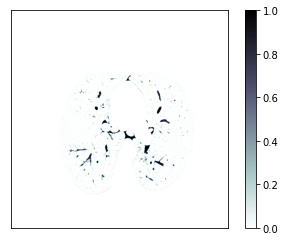

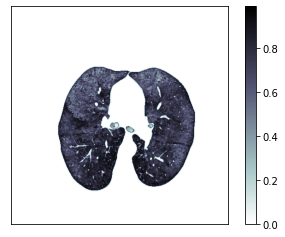

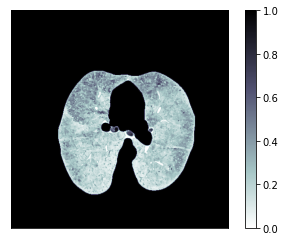

In [32]:
pik_estimate = kem_cv.pik_estimate
for k in range(3):
    show_slice(pik_estimate[k, depth])

- save as dicom file for RadiAnt software

(260, 512, 512, 1)


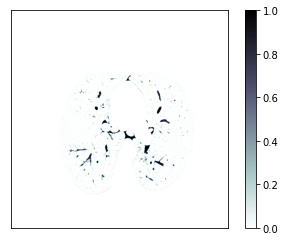

In [33]:
vessel = pik_estimate[0]
vessel = vessel.numpy()
print(vessel.shape)
show_slice(vessel[depth])

In [34]:
# output_folder = f"./[KEM]-{name}/" 

# tmp = transfer_pi_to_dicom(vessel, original_folder, output_folder, 
#                            truncate_threshold=None,
#                            CT_min=CT_min, CT_max=CT_max)

In [35]:
# plt.imshow(tmp[depth])

# $k$-means

In [42]:
kmeans_model = Kmeans(K=3,
                      shape=shape, 
                      training_data=training_data, 
                      position_mask=position_mask, 
                      kmeans_sample_ratio=1/100/training_ratio,
                      testing_data=None)

From function(__init__): Randomly pick 0.009998 data for kmeans.


In [43]:
kmeans_model.kmeans_algorithm(max_steps=50)

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1305: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


(1, 260, 512, 512, 1)


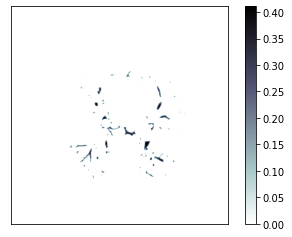

In [46]:
labels = kmeans_model.predict_all_class()
kmeans_results = training_data * tf.cast(labels == 0, tf.float32)
show_slice(kmeans_results[0, depth])

In [25]:
# output_folder = f"./[kmeans]-{name}/" #({datetime.date.today().strftime('%y%m%d')})

# tmp = transfer_pi_to_dicom(kmeans_results[0].numpy(), original_folder, output_folder, 
#                            truncate_threshold=None,
#                            CT_min=CT_min, CT_max=CT_max)

====create a new folder at ./[kmeans]-LIDC-IDRI-0405/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 3170.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 260
====successfully save the dicom files at ./[kmeans]-LIDC-IDRI-0405/====


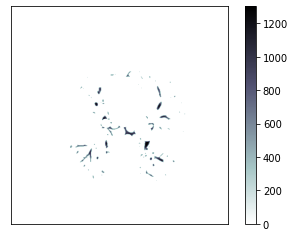

In [26]:
# show_slice(tmp[depth])

# GMM

In [47]:
gmm_model = GMM(K=3, 
                shape=shape, 
                training_data=training_data, 
                position_mask=position_mask, 
                kmeans_sample_ratio=1/100/training_ratio,
                testing_data=None)

From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.00999 data for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 1.683 seconds
	centers: [2.3496437e-01 5.2784208e-02 8.1904327e-05]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 260, 512, 512, 1)
	pi_estimate: (3, 1, 1, 1, 1)
	mu_estimate: (3, 1, 1, 1, 1)
	sigma_estimate: (3, 1, 1, 1, 1)


In [48]:
gmm_model.gmm_algorithm(max_steps=50, epsilon=1e-4, smooth_parameter=1e-20)

From function(gmm_algorithm): Receive max_steps: 50.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.0686471
From function(gmm_algorithm): E step success.
pi_estimator: [0.0076166  0.39952892 0.5934556 ]

mu_estimate: [2.3496437e-01 5.2784208e-02 8.1904327e-05]
sigma_estimator: [0.08423249 0.02541088 0.01443377]
	 Current pi difference: 0.0593789
	 Current mu difference: 0.000602109
	 Current sigma difference: 0.00101381
From function(gmm_algorithm): M step success.
From function(gmm_algorithm): difference: 0.0609949.
---This iteration step costs 0.1179 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.014358
From function(gmm_algorithm): E step success.
pi_estimator: [0.01395842 0.3421719  0.64265305]

mu_estimate: [0.22256161 0.01235205 0.00429377]
sigma_estimator: [0.08393598 0.02599979 0.00613702]
	 Current pi difference: 0.00191681
	 Cur

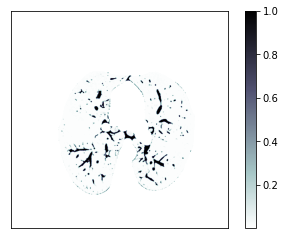

In [49]:
gmm_pik_estimate = gmm_model.pik_estimate
k = 0
show_slice(gmm_pik_estimate[k, depth])

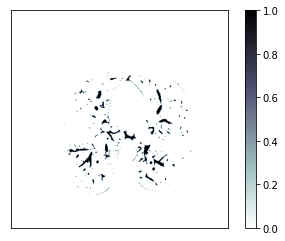

In [50]:
gmm_pik_estimate_2 = tf.cast(gmm_pik_estimate > 0.6, tf.float32)
show_slice(gmm_pik_estimate_2[k, depth])

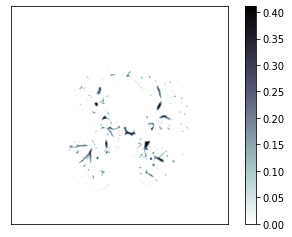

In [51]:
gmm_pik_estimate_2 = tf.cast(gmm_pik_estimate > 0.6, tf.float32)
gmm_pik_estimate_2 = training_data * gmm_pik_estimate_2
show_slice(gmm_pik_estimate_2[k, depth])

In [168]:
output_folder = f"./[GMM]-{name}/" #({datetime.date.today().strftime('%y%m%d')})

tmp = transfer_pi_to_dicom(gmm_pik_estimate[0].numpy(), original_folder, output_folder, 
                           truncate_threshold=None,
                           CT_min=CT_min, CT_max=CT_max)

====create a new folder at ./[GMM]-LIDC-IDRI-0875/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 2283.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 266
====successfully save the dicom files at ./[GMM]-LIDC-IDRI-0875/====


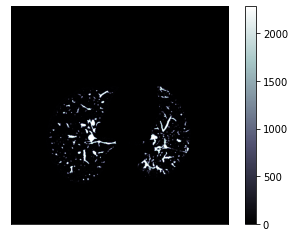

In [169]:
show_slice(tmp[depth])